In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fun
import math

In [ ]:
pip install torch3d

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch3d: filename=torch3d-0.1-py2.py3-none-any.whl size=1096 sha256=ab3721986116812dbc4d793fac126bf919f6eb76219fe918fcb15d84ec9eee21
  Stored in directory: /root/.cache/pip/wheels/ef/f3/2d/016f38ed39e5a41e02180b4439bccdef7adbd43c88bc05e104
  Created wheel for gendr: filename=gendr-0.1.0-cp310-cp310-linux_x86_64.whl size=10568963 sha256=75cc92b71ac397d82f51ded433a66c4a794a9487050d393d6c668fc2a53a63d4
  Stored in directory: /root/.cache/pip/wheels/1e/24/3c/769829ec073aa1a59527e0363b074f3ceb9a0e5ea5de45d0a4
Successfully built torch3d gendr


In [ ]:
pip install torchvision

In [ ]:
pip install --upgrade setuptools

In [ ]:
pip install --upgrade wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.2
    Uninstalling wheel-0.41.2:
      Successfully uninstalled wheel-0.41.2


In [ ]:
pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Loading ShapeNet using dataloader commands from PyTorch

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-ros19lcc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-ros19lcc
  Running command git checkout -q 297020a4b1d7492190cb4a909cafbd2c81a12cb5
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 297020a4b1d7492190cb4a909cafbd2c81a12cb5
  Preparing metadata (setup.py) ... done
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached iopath-0.1.10-py3-none-any.whl
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached portalocker-2.8.2-py3-none-any.whl (17 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch3d
  Running setup.py clean for pytorc

In [ ]:
import numpy as np
import torch

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

ModuleNotFoundError: ignored

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2023-10-30 07:18:46--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-10-30 07:18:46 (23.8 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

SHAPENET_PATH = ""
shapenet_dataset = ShapeNetCore(SHAPENET_PATH)

#### UTIL FUNCTIONS:



In [ ]:

def recursive_detach(t):
    if isinstance(t, torch.Tensor):
        return t.detach()
    elif isinstance(t, list):
        return [recursive_detach(x) for x in t]
    elif isinstance(t, dict):
        return {k: recursive_detach(v) for k, v in t.items()}
    else:
        return t


def batch_mm(matrix, batch):
    """
    https://github.com/pytorch/pytorch/issues/14489
    """
    return torch.stack([matrix.mm(b) for b in batch], dim=0)

def dot(x, y, sparse=False):
    """Wrapper for torch.matmul (sparse vs dense)."""
    if sparse:
        return batch_mm(x, y)
    else:
        return torch.matmul(x, y)



### **Backbone** for the input image:


In [ ]:
class VGG16_encode(nn.Module): # THIS IS FOR THE 2D CONVOLUTIONS HAPPENING
  def __init__(self,n_classes_input = 3):
    super(VGG16_encode, self).__init__()

    self.conv0_1 = nn.Conv2d(n_classes_input, 16, 3, stride = 1, padding = 1)
    self.conv0_2 = nn.Conv2d(16, 16, 3, stride = 1, padding = 1) # changing input classes

    self.conv1_1 = nn.Conv2d(16, 32, 3, stride = 2, padding = 1) # 224 -> 112
    self.conv1_2 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
    self.conv1_3 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)

    self.conv2_1 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1) # 112 -> 56
    self.conv2_2 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
    self.conv2_3 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)

    self.conv3_1 = nn.Conv2d(64, 128, 3, stride = 2, padding = 1) # 56 -> 28
    self.conv3_2 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)
    self.conv3_3 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)

    self.conv4_1 = nn.Conv2d(128, 256, 5, stride = 2, padding = 2) # 28 -> 14
    self.conv4_2 = nn.Conv2d(256, 256, 3, stride = 1, padding = 1)
    self.conv4_3 = nn.Conv2d(256, 256, 3, stride = 1, padding = 1)

    self.conv5_1 = nn.Conv2d(256, 512, 5, stride = 2, padding = 2) # 14 -> 7
    self.conv5_2 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)
    self.conv5_3 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)
    self.conv5_4 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)

  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


  def forward_prop(self, img):
    # ACTIVATION ON EACH LAYER BECAUSE PyTorch HAS DIFFERENT Conv2D ARGUMENTS
    img = fun.relu(self.conv0_1(img))
    img = fun.relu(self.conv0_2(img))

    img = fun.relu(self.conv1_1(img))
    img = fun.relu(self.conv1_2(img))
    img = fun.relu(self.conv1_3(img))

    img = fun.relu(self.conv2_1(img))
    img = fun.relu(self.conv2_2(img))
    img = fun.relu(self.conv2_3(img))
    img2 = torch.squeeze(img)

    img = fun.relu(self.conv3_1(img))
    img = fun.relu(self.conv3_2(img))
    img = fun.relu(self.conv3_3(img))
    img3 = torch.squeeze(img)

    img = fun.relu(self.conv4_1(img))
    img = fun.relu(self.conv4_2(img))
    img = fun.relu(self.conv4_3(img))
    img4 = torch.squeeze(img)

    img = fun.relu(self.conv5_1(img))
    img = fun.relu(self.conv5_2(img))
    img = fun.relu(self.conv5_3(img))
    img5 = torch.squeeze(img)

    return [img2,img3,img4,img5]

class VGG16_decode(nn.Module):
  def __init__(self, input_dim = 512, image_channel = 3):
    super(VGG16_decode, self).__init__()
    # LAYERS FOR DECODING INFO FOR THE POOLING LAYERS IN BETWEEN (for 3D (GCNs))
    self.conv_1 = nn.ConvTranspose2d(input_dim, 256, kernel_size = 2, stride = 2, padding = 0) # 7 -> 14
    self.conv_2 = nn.ConvTranspose2d(512, 128, kernel_size = 4, stride = 2, padding = 1) # 14 -> 28
    self.conv_3 = nn.ConvTranspose2d(256, 64, kernel_size = 4, stride = 2, padding = 1)  # 28 -> 56
    self.conv_4 = nn.ConvTranspose2d(128, 32, kernel_size = 6, stride = 2, padding = 2)   # 56 -> 112
    self.conv_5 = nn.ConvTranspose2d(32, image_channel, kernel_size = 6, stride = 2, padding = 2) # 112 -> 224

  def forward_prop(self,img_feats): # img_feats stands for image_features
    x = fun.relu(self.conv_1(img_feats[-1].unsqueeze(0)))
    x = torch.cat((x, img_feats[-2].unsqueeze(0)), dim = 1)
    x = fun.relu(self.conv_2(x))
    x = torch.cat((x, img_feats[-3].unsqueeze(0)), dim = 1)
    x = fun.relu(self.conv_3(x))
    x = torch.cat((x, img_feats[-4].unsqueeze(0)), dim = 1)
    x = fun.relu(self.conv_4(x))
    x = fun.relu(self.conv_5(x))

    return torch.sigmoid(x)

**GCN section**

 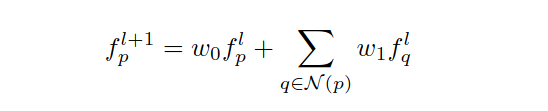

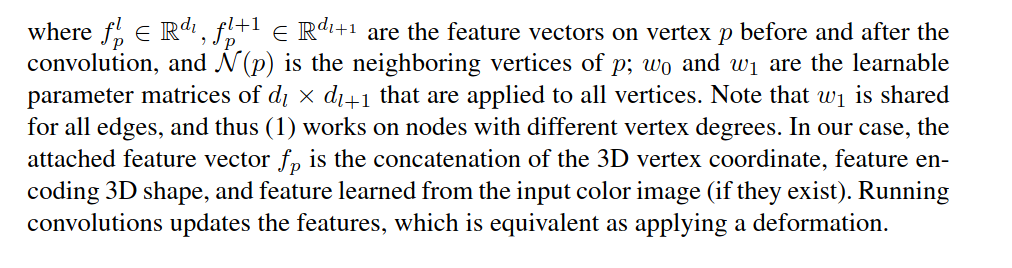



#### 3D mesh is a collection of vertices, edges and faces
#### Can be written into a Graph M=f(V,E,F)

In [ ]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from scipy.sparse import coo_matrix

In [ ]:
class GConv(nn.Module):
    # Simple GCN layer
    # Similar to https://arxiv.org/abs/1609.02907

    def __init__(self, in_features, out_features, adj_mat, bias=True):
        super(GConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.adj_mat = nn.Parameter(adj_mat, requires_grad=False)
        self.weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        # Following https://github.com/Tong-ZHAO/Pixel2Mesh-Pytorch/blob/a0ae88c4a42eef6f8f253417b97df978db842708/model/gcn_layers.py#L45
        # Amd https://github.com/noahcao/Pixel2Mesh/blob/master/models/layers/gconv.py
        # different from the original implementation of P2M
        self.loop_weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        if bias:
            self.bias = nn.Parameter(torch.zeros((out_features,), dtype=torch.float))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.data)
        nn.init.xavier_uniform_(self.loop_weight.data)

    def forward(self, inputs):
        support = torch.matmul(inputs, self.weight)
        support_loop = torch.matmul(inputs, self.loop_weight)
        output = dot(self.adj_mat, support, True) + support_loop
        if self.bias is not None:
            ret = output + self.bias
        else:
            ret = output
        return ret

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GUnpooling(nn.Module):

    # Graph Unpooling layer, aims to add additional vertices to the graph.
    # The middle point of each edges are added, and its feature is simply
    # the average of the two edge vertices.
    # Three middle points are connected in each triangle.


    def __init__(self, unpool_idx):
        super(GUnpooling, self).__init__()
        self.unpool_idx = unpool_idx
        # save dim info
        self.in_num = torch.max(unpool_idx).item()
        self.out_num = self.in_num + len(unpool_idx)

    def forward(self, inputs):
        new_features = inputs[:, self.unpool_idx].clone()
        new_vertices = 0.5 * new_features.sum(2)
        output = torch.cat([inputs, new_vertices], 1)

        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_num) + ' -> ' \
               + str(self.out_num) + ')'

from torch.nn import Threshold


class GProjection(nn.Module):

    # Graph Projection layer, which pool 2D features to mesh
    # The layer projects a vertex of the mesh to the 2D image and use
    # bi-linear interpolation to get the corresponding feature.
    # bi-linear here means the average of two neighbours

    def __init__(self, mesh_pos, camera_f, camera_c, bound=0, tensorflow_compatible=False):
        super(GProjection, self).__init__()
        self.mesh_pos, self.camera_f, self.camera_c = mesh_pos, camera_f, camera_c
        self.threshold = None
        self.bound = 0
        self.tensorflow_compatible = tensorflow_compatible
        if self.bound != 0:
            self.threshold = Threshold(bound, bound)

    def bound_val(self, x):
        """
        given x, return min(threshold, x), in case threshold is not None
        """
        if self.bound < 0:
            return -self.threshold(-x)
        elif self.bound > 0:
            return self.threshold(x)
        return x

    @staticmethod
    def image_feature_shape(img):
        return np.array([img.size(-1), img.size(-2)])

    def project_tensorflow(self, x, y, img_size, img_feat):
        x = torch.clamp(x, min=0, max=img_size[1] - 1)
        y = torch.clamp(y, min=0, max=img_size[0] - 1)

        # it's tedious and contains bugs...
        # when x1 = x2, the area is 0, therefore it won't be processed
        # keep it here to align with tensorflow version   ## COMMENTS BY ORIGINAL AUTHOR
        x1, x2 = torch.floor(x).long(), torch.ceil(x).long()
        y1, y2 = torch.floor(y).long(), torch.ceil(y).long()

        Q11 = img_feat[:, x1, y1].clone()
        Q12 = img_feat[:, x1, y2].clone()
        Q21 = img_feat[:, x2, y1].clone()
        Q22 = img_feat[:, x2, y2].clone()

        weights = torch.mul(x2.float() - x, y2.float() - y)
        Q11 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q11, 0, 1))

        weights = torch.mul(x2.float() - x, y - y1.float())
        Q12 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q12, 0, 1))

        weights = torch.mul(x - x1.float(), y2.float() - y)
        Q21 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q21, 0, 1))

        weights = torch.mul(x - x1.float(), y - y1.float())
        Q22 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q22, 0, 1))

        output = Q11 + Q21 + Q12 + Q22
        return output

    def forward(self, resolution, img_features, inputs):
        half_resolution = (resolution - 1) / 2
        camera_c_offset = np.array(self.camera_c) - half_resolution
        # map to [-1, 1]
        # not sure why they render to negative x
        positions = inputs + torch.tensor(self.mesh_pos, device=inputs.device, dtype=torch.float)
        w = -self.camera_f[0] * (positions[:, :, 0] / self.bound_val(positions[:, :, 2])) + camera_c_offset[0]
        h = self.camera_f[1] * (positions[:, :, 1] / self.bound_val(positions[:, :, 2])) + camera_c_offset[1]

        if self.tensorflow_compatible:
            # to align with tensorflow
            # this is incorrect, I believe
            w += half_resolution[0]
            h += half_resolution[1]

        else:
            # directly do clamping
            w /= half_resolution[0]
            h /= half_resolution[1]

            # clamp to [-1, 1]
            w = torch.clamp(w, min=-1, max=1)
            h = torch.clamp(h, min=-1, max=1)

        feats = [inputs]
        for img_feature in img_features:
            feats.append(self.project(resolution, img_feature, torch.stack([w, h], dim=-1)))

        output = torch.cat(feats, 2)

        return output

    def project(self, img_shape, img_feat, sample_points):
        """
        :param img_shape: raw image shape
        :param img_feat: [batch_size x channel x h x w]
        :param sample_points: [batch_size x num_points x 2], in range [-1, 1]
        :return: [batch_size x num_points x feat_dim]
        """
        if self.tensorflow_compatible:
            feature_shape = self.image_feature_shape(img_feat)
            points_w = sample_points[:, :, 0] / (img_shape[0] / feature_shape[0])
            points_h = sample_points[:, :, 1] / (img_shape[1] / feature_shape[1])
            output = torch.stack([self.project_tensorflow(points_h[i], points_w[i],
                                                          feature_shape, img_feat[i]) for i in range(img_feat.size(0))], 0)
        else:
            output = fun.grid_sample(img_feat, sample_points.unsqueeze(1))
            output = torch.transpose(output.squeeze(2), 1, 2)

        return output
class GResBlock(nn.Module):

    def __init__(self, in_dim, hidden_dim, adj_mat, activation=None):
        super(GResBlock, self).__init__()

        self.conv1 = GConv(in_features=in_dim, out_features=hidden_dim, adj_mat=adj_mat)
        self.conv2 = GConv(in_features=hidden_dim, out_features=in_dim, adj_mat=adj_mat)
        self.activation = fun.relu if activation else None

    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.activation:
            x = self.activation(x)
        x = self.conv2(x)
        if self.activation:
            x = self.activation(x)

        return (inputs + x) * 0.5


class GBottleneck(nn.Module):

    def __init__(self, block_num, in_dim, hidden_dim, out_dim, adj_mat, activation=None):
        super(GBottleneck, self).__init__()

        resblock_layers = [GResBlock(in_dim=hidden_dim, hidden_dim=hidden_dim, adj_mat=adj_mat, activation=activation)
                           for _ in range(block_num)]
        self.blocks = nn.Sequential(*resblock_layers)
        self.conv1 = GConv(in_features=in_dim, out_features=hidden_dim, adj_mat=adj_mat)
        self.conv2 = GConv(in_features=hidden_dim, out_features=out_dim, adj_mat=adj_mat)
        self.activation = fun.relu if activation else None

    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.activation:
            x = self.activation(x)
        x_hidden = self.blocks(x)
        x_out = self.conv2(x_hidden)

        return x_out, x_hidden

# BACKPROP
MOSTLY NO USE RN

# LOSS CALCULATION (CHAMFER, LAPLACIAN, etc)

In [ ]:
from torch.autograd import Function
import torch.nn.functional as F

In [ ]:
# import chamfer #This module is going to be used for Chamfer Loss calculations

#This is used for Cross Entropy Loss, giving us loss between different labels associated with our
#generated model and ground truth.

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        labels = targets["labels"]
        loss = self.cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        return loss, {"loss": loss, "acc": correct / total}

#This class will have function required to calculate Chamfer Distance and Chamfer Loss

# class ChamferFunction(Function):
#     staticmethod
#     def forward(ctx, xyz1, xyz2):
#         batchsize, n, _ = xyz1.size()
#         _, m, _ = xyz2.size()

#         dist1 = torch.zeros(batchsize, n)
#         dist2 = torch.zeros(batchsize, m)

#         idx1 = torch.zeros(batchsize, n).type(torch.IntTensor)
#         idx2 = torch.zeros(batchsize, m).type(torch.IntTensor)

#         # Following commented variables can be given cuda when required.

#         # dist1 = dist1
#         # dist2 = dist2
#         # idx1 = idx1
#         # idx2 = idx2

#         chamfer.forward(xyz1, xyz2, dist1, dist2, idx1, idx2)
#         ctx.save_for_backward(xyz1, xyz2, idx1, idx2)
#         return dist1, dist2, idx1, idx2

#     staticmethod
#     def backward(ctx, graddist1, graddist2, _idx1, _idx2):
#         xyz1, xyz2, idx1, idx2 = ctx.saved_tensors
#         graddist1 = graddist1.contiguous()
#         graddist2 = graddist2.contiguous()

#         gradxyz1 = torch.zeros(xyz1.size())
#         gradxyz2 = torch.zeros(xyz2.size())

#         # Following commented variables can be givpien cuda when required.

#         # gradxyz1 = gradxyz1
#         # gradxyz2 = gradxyz2
#         chamfer.backward(xyz1, xyz2, gradxyz1, gradxyz2, graddist1, graddist2, idx1, idx2)
#         return gradxyz1, gradxyz2


# class ChamferDist(nn.Module):
#     def __init__(self):
#         super(ChamferDist, self).__init__()

#     def forward(self, input1, input2):
#         return ChamferFunction.apply(input1, input2)

import torch.nn.functional as F

# from models.layers.chamfer_wrapper import ChamferDist


class P2MLoss(nn.Module):
    def __init__(self, options, ellipsoid):
        super().__init__()
        self.options = options
        self.l1_loss = nn.L1Loss(reduction='mean')
        self.l2_loss = nn.MSELoss(reduction='mean')
        # self.chamfer_dist = ChamferDist()
        self.laplace_idx = nn.ParameterList([
            nn.Parameter(idx, requires_grad=False) for idx in ellipsoid.laplace_idx])
        self.edges = nn.ParameterList([
            nn.Parameter(edges, requires_grad=False) for edges in ellipsoid.edges])

    def edge_regularization(self, pred, edges):
        """
        :param pred: batch_size * num_points * 3
        :param edges: num_edges * 2
        :return:
        """
        return self.l2_loss(pred[:, edges[:, 0]], pred[:, edges[:, 1]]) * pred.size(-1)

    @staticmethod
    def laplace_coord(inputs, lap_idx):
        """
        :param inputs: nodes Tensor, size (n_pts, n_features = 3)
        :param lap_idx: laplace index matrix Tensor, size (n_pts, 10)
        for each vertex, the laplace vector shows: [neighbor_index * 8, self_index, neighbor_count]

        :returns
        The laplacian coordinates of input with respect to edges as in lap_idx
        """

        indices = lap_idx[:, :-2]
        invalid_mask = indices < 0
        all_valid_indices = indices.clone()
        all_valid_indices[invalid_mask] = 0  # do this to avoid negative indices

        vertices = inputs[:, all_valid_indices]
        vertices[:, invalid_mask] = 0
        neighbor_sum = torch.sum(vertices, 2)
        neighbor_count = lap_idx[:, -1].float()
        laplace = inputs - neighbor_sum / neighbor_count[None, :, None]

        return laplace

    def laplace_regularization(self, input1, input2, block_idx):
        """
        :param input1: vertices tensor before deformation
        :param input2: vertices after the deformation
        :param block_idx: idx to select laplace index matrix tensor
        :return:

        if different than 1 then adds a move loss as in the original TF code
        """

        lap1 = self.laplace_coord(input1, self.laplace_idx[block_idx])
        lap2 = self.laplace_coord(input2, self.laplace_idx[block_idx])
        laplace_loss = self.l2_loss(lap1, lap2) * lap1.size(-1)
        move_loss = self.l2_loss(input1, input2) * input1.size(-1) if block_idx > 0 else 0
        return laplace_loss, move_loss

    def normal_loss(self, gt_normal, indices, pred_points, adj_list):
        edges = F.normalize(pred_points[:, adj_list[:, 0]] - pred_points[:, adj_list[:, 1]], dim=2)
        nearest_normals = torch.stack([t[i] for t, i in zip(gt_normal, indices.long())])
        normals = F.normalize(nearest_normals[:, adj_list[:, 0]], dim=2)
        cosine = torch.abs(torch.sum(edges * normals, 2))
        return torch.mean(cosine)

    def image_loss(self, gt_img, pred_img):
        rect_loss = F.binary_cross_entropy(pred_img, gt_img)
        return rect_loss

    def forward(self, outputs, targets):
        """
        :param outputs: outputs from P2MModel
        :param targets: targets from input
        :return: loss, loss_summary (dict)
        """

        chamfer_loss, edge_loss, normal_loss, lap_loss, move_loss = 0., 0., 0., 0., 0.
        lap_const = [0.2, 1., 1.]

        gt_coord, gt_normal, gt_images = targets["points"], targets["normals"], targets["images"]
        pred_coord, pred_coord_before_deform = outputs["pred_coord"], outputs["pred_coord_before_deform"]
        image_loss = 0.
        if outputs["reconst"] is not None and self.options.weights.reconst != 0:
            image_loss = self.image_loss(gt_images, outputs["reconst"])

        for i in range(3):
            dist1, dist2, idx1, idx2 = self.chamfer_dist(gt_coord, pred_coord[i])
            chamfer_loss += self.options.weights.chamfer[i] * (torch.mean(dist1) +
                                                               self.options.weights.chamfer_opposite * torch.mean(dist2))
            normal_loss += self.normal_loss(gt_normal, idx2, pred_coord[i], self.edges[i])
            edge_loss += self.edge_regularization(pred_coord[i], self.edges[i])
            lap, move = self.laplace_regularization(pred_coord_before_deform[i],
                                                                   pred_coord[i], i)
            lap_loss += lap_const[i] * lap
            move_loss += lap_const[i] * move

        loss = chamfer_loss + image_loss * self.options.weights.reconst + \
               self.options.weights.laplace * lap_loss + \
               self.options.weights.move * move_loss + \
               self.options.weights.edge * edge_loss + \
               self.options.weights.normal * normal_loss

        loss = loss * self.options.weights.constant

        return loss, {
            "loss": loss,
            "loss_chamfer": chamfer_loss,
            "loss_edge": edge_loss,
            "loss_laplace": lap_loss,
            "loss_move": move_loss,
            "loss_normal": normal_loss,
        }

ModuleNotFoundError: ignored

In [ ]:
pip install functions


  Preparing metadata (setup.py) ... done
  Created wheel for functions: filename=functions-0.7.0-py3-none-any.whl size=3037 sha256=a60296e117cea12aa58cc4724a3c29ec75d8aa552c3e8133837b68044ac10d3b
  Stored in directory: /root/.cache/pip/wheels/92/90/bc/01eb2f163bcfa49c7ad5072fbe9d243038368b9001ec26a9da
Successfully built functions


In [ ]:
pip install utils


# EVALUATION, TRAINING etc

In [ ]:
from functions.base import CheckpointRunner
from models.layers.chamfer_wrapper import ChamferDist
from utils.vis.renderer import MeshRenderer
from utils.mesh import Ellipsoid


class Evaluator(CheckpointRunner):

    def __init__(self, options, logger: Logger, writer, shared_model=None):
        super().__init__(options, logger, writer, training=False, shared_model=shared_model)

    def init_fn(self, shared_model=None, **kwargs):
        if self.options.model.name == "pixel2mesh":
            # Renderer for visualization
          self.renderer = MeshRenderer(self.options.dataset.camera_f, self.options.dataset.camera_c, self.options.dataset.mesh_pos)
            # Initializing distance module
          self.chamfer = ChamferDist()
            # create ellipsoid
          self.ellipsoid = Ellipsoid(self.options.dataset.mesh_pos)
            # use weighted mean evaluation metrics or not
          self.weighted_mean = self.options.test.weighted_mean
        else:
          self.renderer = None
        self.num_classes = self.options.dataset.num_classes

        if shared_model is not None:
          self.model = shared_model
        else:
          if self.options.model.name == "pixel2mesh":
                # create model
            self.model = P2MModel(self.options.model, self.ellipsoid, self.options.dataset.camera_f, self.options.dataset.camera_c, self.options.dataset.mesh_pos)
          elif self.options.model.name == "classifier":
            self.model = Classifier(self.options.model, self.options.dataset.num_classes)
          else:
            raise NotImplementedError("Your model is not found")
            self.model = torch.nn.DataParallel(self.model, device_ids=self.gpus).cuda()
            # Evaluate step count, useful in summary
        self.evaluate_step_count = 0
        self.total_step_count = 0

    def models_dict(self):
      return {'model': self.model}

    def evaluate_f1(self, dis_to_pred, dis_to_gt, pred_length, gt_length, thresh):
      recall = np.sum(dis_to_gt < thresh) / gt_length
      prec = np.sum(dis_to_pred < thresh) / pred_length
      return 2 * prec * recall / (prec + recall + 1e-8)

    def evaluate_chamfer_and_f1(self, pred_vertices, gt_points, labels):
        # calculate accurate chamfer distance; ground truth points with different lengths;
        # therefore cannot be batched
      batch_size = pred_vertices.size(0)
      pred_length = pred_vertices.size(1)
      for i in range(batch_size):
        gt_length = gt_points[i].size(0)
        label = labels[i].cpu().item()
        d1, d2, i1, i2 = self.chamfer(pred_vertices[i].unsqueeze(0), gt_points[i].unsqueeze(0))
        d1, d2 = d1.cpu().numpy(), d2.cpu().numpy()  # convert to millimeter
        self.chamfer_distance[label].update(np.mean(d1) + np.mean(d2))
        self.f1_tau[label].update(self.evaluate_f1(d1, d2, pred_length, gt_length, 1E-4))
        self.f1_2tau[label].update(self.evaluate_f1(d1, d2, pred_length, gt_length, 2E-4))

    def evaluate_accuracy(self, output, target):
      """Computes the accuracy over the k top predictions for the specified values of k"""
      top_k = [1, 5]
      maxk = max(top_k)
      batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    for k in top_k:
      correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
      acc = correct_k.mul_(1.0 / batch_size)
      if k == 1:
        self.acc_1.update(acc)
      elif k == 5:
        self.acc_5.update(acc)

    def evaluate_step(self, input_batch):
      self.model.eval()

        # Run inference
      with torch.no_grad():
            # Get ground truth
        images = input_batch['images']

        out = self.model(images)

        if self.options.model.name == "pixel2mesh":
          pred_vertices = out["pred_coord"][-1]
          gt_points = input_batch["points_orig"]
          if isinstance(gt_points, list):
            gt_points = [pts.cuda() for pts in gt_points]
            self.evaluate_chamfer_and_f1(pred_vertices, gt_points, input_batch["labels"])
          elif self.options.model.name == "classifier":
            self.evaluate_accuracy(out, input_batch["labels"])
      return out

    # noinspection PyAttributeOutsideInit
    def evaluate(self):
      self.logger.info("Running evaluations...")

        # clear evaluate_step_count, but keep total count uncleared
      self.evaluate_step_count = 0

      test_data_loader = DataLoader(self.dataset,
                                      batch_size=self.options.test.batch_size * self.options.num_gpus,
                                      num_workers=self.options.num_workers,
                                      pin_memory=self.options.pin_memory,
                                      shuffle=self.options.test.shuffle,
                                      collate_fn=self.dataset_collate_fn)
      if self.options.model.name == "pixel2mesh":
            self.chamfer_distance = [AverageMeter() for _ in range(self.num_classes)]
            self.f1_tau = [AverageMeter() for _ in range(self.num_classes)]
            self.f1_2tau = [AverageMeter() for _ in range(self.num_classes)]
      elif self.options.model.name == "classifier":
            self.acc_1 = AverageMeter()
            self.acc_5 = AverageMeter()
      # Iterate over all batches in an epoch
      for step, batch in enumerate(test_data_loader):
            # Send input to GPU
        batch = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

            # Run evaluation step
        out = self.evaluate_step(batch)
        # Tensorboard logging every summary_steps steps
        if self.evaluate_step_count % self.options.test.summary_steps == 0:
          self.evaluate_summaries(batch, out)

            # add later to log at step 0
          self.evaluate_step_count += 1
          self.total_step_count += 1

      for key, val in self.get_result_summary().items():
            scalar = val
            if isinstance(val, AverageMeter):
                scalar = val.avg
            self.logger.info("Test [%06d] %s: %.6f" % (self.total_step_count, key, scalar))
            self.summary_writer.add_scalar("eval_" + key, scalar, self.total_step_count + 1)


    def average_of_average_meters(self, average_meters):
      s = sum([meter.sum for meter in average_meters])
      c = sum([meter.count for meter in average_meters])
      weighted_avg = s / c if c > 0 else 0.
      avg = sum([meter.avg for meter in average_meters]) / len(average_meters)
      ret = AverageMeter()
      if self.weighted_mean:
        ret.val, ret.avg = avg, weighted_avg
      else:
        ret.val, ret.avg = weighted_avg, avg
      return ret

    def get_result_summary(self):
      if self.options.model.name == "pixel2mesh":
        return {
                "cd": self.average_of_average_meters(self.chamfer_distance),
                "f1_tau": self.average_of_average_meters(self.f1_tau),
                "f1_2tau": self.average_of_average_meters(self.f1_2tau),
               }
      elif self.options.model.name == "classifier":
        return {
                "acc_1": self.acc_1,
                "acc_5": self.acc_5,
               }

    def evaluate_summaries(self, input_batch, out_summary):
        self.logger.info("Test Step %06d/%06d (%06d) " % (self.evaluate_step_count, len(self.dataset) // (self.options.num_gpus * self.options.test.batch_size), self.total_step_count,) + ", ".join([key + " " + (str(val) if isinstance(val, AverageMeter) else "%.6f" % val)
          for key, val in self.get_result_summary().items()]))
        self.summary_writer.add_histogram("eval_labels", input_batch["labels"].cpu().numpy(),
                                          self.total_step_count)
        if self.renderer is not None:
            # Do visualization for the first 2 images of the batch
            render_mesh = self.renderer.p2m_batch_visualize(input_batch, out_summary, self.ellipsoid.faces)
            self.summary_writer.add_image("eval_render_mesh", render_mesh, self.total_step_count)




SyntaxError: ignored